## Московские цены на аренду комнаты

#### Задача

- При поиске жилья одним из критериев может быть адекватность цены аренды, 
она не может быть слишком завышена или занижена, идеальный случай, когда она немного занижена.
Чтобы найти адекватную стоимость сгенерим признаки, влияющие на конечную стоимость и
построим модель, которая бы предсказывала бы ее.

- Было бы интересно оценить стоимость сдачи комнаты в ГЗ


Установим нужные нам пакеты

In [ ]:
!pip install shapely folium geopandas lightgbm tqdm shap geopy pyshp

In [ ]:
!wget https://raw.githubusercontent.com/shestakoff/sphere-ml-intro/lecture-3-geo/lecture03-geo/flat_prices_room.csv.zip

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import folium
import matplotlib as mpl
import matplotlib.cm as cm
pd.options.display.max_columns = 200

In [2]:
df = pd.read_csv('flat_prices_room.csv.zip', compression='zip')
df.head(3)

,lat,lon,ID объявления,Адрес,Балкон,"Высота потолков, м",Дом,Дополнительно,Количество комнат,Лифт,Метро,Можно с детьми/животными,Мусоропровод,Название ЖК,Окна,Описание,Парковка,"Площадь комнат, м2","Площадь, м2",Ремонт,Санузел,Серия дома,Состав съемщиков,Ссылка на объявление,Телефоны,Тип,Цена,floor,max_floor,Холодильник,Мебель в комнатах,Мебель на кухне,Ванна,Интернет,Телевизор,Душевая кабина,rooms,Изолированная,room_area,total_area,long_rent,Комунальные услуги,price,url
0,55.846067,37.195409,156430705,"Московская область, Красногорск городской окру...",NaN,2.70,"1/1, Деревянный","Мебель в комнатах, Мебель на кухне, Душевая ка...","1(2), Изолированная",NaN,NaN,NaN,NaN,NaN,NaN,Комната 16м2 в жилом доме с отдельным входом о...,NaN,NaN,16.0/35.0/12.0,Косметический,Совмещенный (1),NaN,Семья,https://www.cian.ru/rent/flat/156430705,+79250510387,Комната,"16000.0 руб./ За месяц, Залог - 16000 руб., Ко...",1,1,True,True,True,False,False,True,True,0,True,16.0,35.0,True,True,16000.0,https://www.cian.ru/rent/flat/156430705
1,55.978941,37.192633,195369878,"Москва, Зеленоград, к802",NaN,2.64,"1/9, Панельный","Мебель в комнатах, Мебель на кухне, Ванна, Сти...","1(3), Изолированная",Пасс (1),NaN,NaN,Да,NaN,Во двор,Комната есть в наличии! Срочно! Сдам комнату в...,NaN,NaN,11.0/65.0/6.0,Косметический,Раздельный (1),NaN,Любой,https://www.cian.ru/rent/flat/195369878,+79037136464,Комната,"10000.0 руб./ За месяц, Коммунальные услуги вк...",1,9,True,True,True,True,False,False,False,0,True,11.0,65.0,True,True,10000.0,https://www.cian.ru/rent/flat/195369878
2,55.596442,37.201284,194973629,"Москва, Марушкинское поселение, д. Марушкино, 12",NaN,NaN,"5/12, Панельный","Мебель в комнатах, Мебель на кухне, Ванна, Тел...","1(3), Изолированная",Пасс (1),NaN,Можно с детьми,Да,NaN,Во двор,Это д. Марушкино д.12 рядом с Кокошкино и ста...,NaN,NaN,16.0/56.0/7.0,Косметический,Раздельный (1),NaN,Любой,https://www.cian.ru/rent/flat/194973629,"+79035254111, +79661445343",Комната,"12000.0 руб./ За месяц, Коммунальные услуги вк...",5,12,True,True,True,True,False,True,False,0,True,16.0,56.0,True,True,12000.0,https://www.cian.ru/rent/flat/194973629


In [3]:
len(df)

3181

Параметры комнаты в Главном Здании МГУ

In [4]:
gz_parameters = {
    'lat': 55.703672, 
    'lon': 37.529788, 
    'Дом': '9/30 Кирпичный', 
    'Количество комнат': 1, 
    'Метро': 'Университет (20 мин пешком)',
    'Можно с детьми/животными': np.nan,
    'Мусоропровод': 'Да',
    'Окна': 'Во двор',
    'Парковка': 'наземная',
    'Площадь комнат, м2': 10,
    'Площадь, м2': '10/4/0',
    'Ремонт': 'Косметический',
    'Санузел': 'Раздельный (1)',
    'Тип': 'Комната',
    'floor': 9,
    'max_floor': 30,
    'Холодильник': False,
    'Мебель в комнатах': True,
    'Мебель на кухне': False,
    'Ванна': False,
    'Интернет': True,
    'Телевизор': False,
    'Душевая кабина': True,
    'rooms': 1,
    'Изолированная': True,
    'room_area': 10,
    'total_area': 14,
    'long_rent': True,
    'Комунальные услуги': False,
    'Состав съемщиков': 'Любой',
    'ID  объявления':  'gz_room',
    'price': 15000
}

Добавим в общий датафрейм

In [5]:
df = pd.concat([df, pd.DataFrame([gz_parameters])], ignore_index=True)

In [6]:
df = df[df['Тип'] == 'Комната']

Отфильтруем значения в которых нет координат

In [7]:
df = df[~df['lat'].isnull()]

#### Для отображения геообъектов в jupyter notebook - folium

In [8]:
center = {'lat': 55.756204, 'lon': 37.616675}

In [9]:
map_folium = folium.Map(location=(center['lat'], center['lon']),
                        tiles='Stamen Toner',
                        zoom_start=11)

Пройдемся по 1000 случайным строчкам в датафрейме и создадим на основе их folium объекты CircleMarker и добавим их на карту
При этом воспользуемся функциями для преобразования чисел в RGB цвет

In [10]:
norm = mpl.colors.Normalize(vmin=0, vmax=50000)
cmap = cm.plasma
colormap= cm.ScalarMappable(norm=norm, cmap=cmap)
for ind, row in df.sample(1000).iterrows():
    folium.CircleMarker([row['lat'], row['lon']],
                        radius=7,
                        popup='{}'.format('<br>'.join(map(str, [row['price']]))),
                        color=mpl.colors.rgb2hex((colormap.to_rgba(row['price']))),
                        fill_color=mpl.colors.rgb2hex((colormap.to_rgba(row['price']))),
                        fill=True, 
                        fill_opacity=0.9
                       ).add_to(map_folium)
map_folium

#### Найдем расстояние каждой точки до центра

In [11]:
from geopy import distance
df['distance_to_center'] = df.apply(lambda r: distance.distance((r['lat'], r['lon']), 
                                                                (center['lat'], center['lon'])
                                                               ).meters, axis=1)

Отфильтруем удаленные объекта от центра Москвы

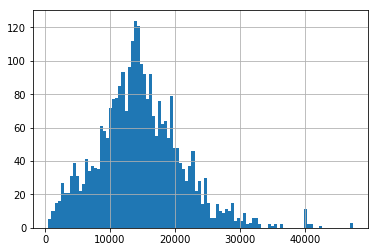

In [12]:
df = df[df['distance_to_center'] < 5e4]
df['distance_to_center'].hist(bins=100)
df = df.reset_index(drop=True)

#### Извлечем признаки из сырых данных

In [13]:
df['Дом'].value_counts().head()

2/5, Кирпичный    79
4/5, Кирпичный    72
3/5, Кирпичный    71
5/5, Кирпичный    68
4/9, Панельный    67
Name: Дом, dtype: int64

Извлечем материал стен

In [14]:
df['wall_material'] = df['Дом'].str.split(',').str[1]

In [15]:
df['Метро'].value_counts().head()

м. Выхино (15 мин на машине)      12
м. Выхино (15 мин пешком)         11
м. Сходненская (15 мин пешком)    10
м. Выхино (10 мин на машине)      10
м. Отрадное (15 мин пешком)       10
Name: Метро, dtype: int64

Рассчитаем время до метро пешком. В случае если записано время на машине, то умнжим его на 5

In [16]:
df['metro_on_car'] = df['Метро'].str.contains('машине').astype(float)
df['metro_on_foot'] = df['Метро'].str.contains('пешком').astype(float)
df['minute_to_metro'] = df['Метро'].str.split('(').str[1].str.split(' ').str[0]
df['minute_to_metro'] = pd.to_numeric(df['minute_to_metro'], errors='coerce')
minutes_on_foot_vs_car = 5
df['minute_to_metro'] = df.apply(lambda r: r['minute_to_metro'] * minutes_on_foot_vs_car 
                                 if r['metro_on_foot'] else r['minute_to_metro'], axis=1)

In [17]:
df['Можно с детьми/животными'].value_counts()

Можно с детьми                       317
Можно с детьми, Можно с животными    206
Можно с животными                     80
Name: Можно с детьми/животными, dtype: int64

Извлечем остальные признаки из колонок

В поле "Балкон" содержится различные слова либо "Балкон" либо "Лоджия", вычленим от туда эти слова и сгенерим бинарный признак. То же самое с полем "Можно с детьми/животными" и "Окна"

In [18]:
df['Балкон_Лоджия'] = df['Балкон'].str.contains('Лоджия').astype(float)
df['Балкон_Балкон'] = df['Балкон'].str.contains('Балкон').astype(float)

df['with_childs'] = df['Можно с детьми/животными'].str.contains('Можно с детьми').astype(float)
df['with_pets'] = df['Можно с детьми/животными'].str.contains('Можно с животными').astype(float)

df['windows_to_street'] = df['Окна'].str.contains('улицу').astype(float)
df['windows_to_courtyard'] = df['Окна'].str.contains('двор').astype(float)

In [19]:
df['Мусоропровод'] = (df['Мусоропровод'] == 'Да').astype(float)

В названии ЖК присутсвует год постройки для новых ЖК

In [20]:
df['building_year'] = pd.to_numeric(df['Название ЖК'].str.split(' ').str[-1], errors='coerce')
df['building_year'] = df['building_year']

Разобьем поле "Площадь" '10/10/10' на три

In [21]:
for i in range(3):
    df[f'square_{i}'] = pd.to_numeric(df['Площадь, м2'].str.split('/').str[i], errors='coerce')
df['Площадь комнат, м2'] = pd.to_numeric(df['Площадь комнат, м2'], errors='coerce')

Заменим  значения выпадающие из диапазона возможных

In [22]:
df.loc[(df['Площадь комнат, м2'] > 300) | (df['Площадь комнат, м2'] < 0), 'Площадь комнат, м2'] = np.nan

In [23]:
df['Парковка'].value_counts()

наземная          730
многоуровневая      7
подземная           7
Name: Парковка, dtype: int64

Преобразуем строковые категориальные признаки в число

In [24]:
cat_features = ['Парковка', 'Санузел', 'wall_material', 'Состав съемщиков']
for col in cat_features:
    df[col] = df[col].astype('category').cat.codes

#### Построим модель на только что сгенеренных признаках

Отфильтруем таргет - цену от выбросов. Для борьбы с выбросами можно использовать также преобразование log(1 + x)

In [25]:
df = df[(df['price'] < 40000) & (df['price'] > 5000)]
df = df.reset_index(drop=True)

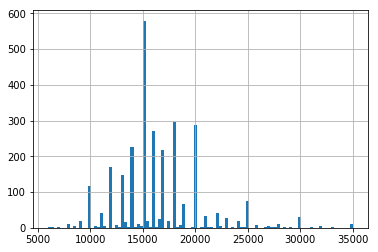

In [26]:
df['price'].hist(bins=100)

Обучим lightgbm модель на основе сгенерированных признаков, в качества таргета возьмем цену. Разбивку на трейн и тест сделаем случайную с помощью функции train_test_split с размером теста 0.25 от величины целого датасета

In [27]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

/Users/p.logachev/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [28]:
trash_columns = ['ID  объявления', 'Адрес', 'Тип', 'Телефоны', 
                 'Ссылка на объявление', 'Балкон', 'Лифт', 
                 'Дом', 'Дополнительно', 'Можно с детьми/животными', 'Метро', 
                 'Мусоропровод', 'Название ЖК', 'Количество комнат', 'Окна',
                 'Ремонт', 'Площадь, м2', 'Серия дома', 
                 'Цена', 'url', 'Описание', 'lat', 'lon']
target = 'price'

In [29]:
features = list(set(df.columns) - set(trash_columns + [target]))
train, test = train_test_split(df, random_state=1337)

lgb_data_train = lgb.Dataset(train[features].values, train[target])
lgb_data_test = lgb.Dataset(test[features].values, test[target])
params = {
    'objective':'regression', 
    'metric': 'mae',
    'learning_rate': 0.05, 
    'nthread': 1,
    'reg_lambda': 30
}

model = lgb.train(params, lgb_data_train, 
                  valid_sets=[lgb_data_test, lgb_data_train],
                  num_boost_round=3500,
                  early_stopping_rounds=100, verbose_eval=40)

Training until validation scores don't improve for 100 rounds
[40]	training's l1: 2089.46	valid_0's l1: 2240.44
[80]	training's l1: 1848.97	valid_0's l1: 2164.94
[120]	training's l1: 1706.61	valid_0's l1: 2146.41
[160]	training's l1: 1594.27	valid_0's l1: 2162.12
[200]	training's l1: 1501.44	valid_0's l1: 2179.32
Early stopping, best iteration is:
[116]	training's l1: 1718.39	valid_0's l1: 2145.88


##### Цена сдачи однокомнатной квартиры в гз

In [30]:
pred = model.predict(test[test['ID  объявления'] == 'gz_room'][features])
pred

array([ 16382.19974104])

Оценим влияние каждого фактора с помощью feature importance - количество узлов приходящихся на каждый признак

In [31]:
(pd.DataFrame({'name': features, 
              'importance': model.feature_importance()})
 .sort_values('importance', ascending=False)
 .head(10))

,importance,name
28,566,Column_28
18,419,Column_18
0,366,Column_0
12,284,Column_12
16,278,Column_16
11,209,Column_11
29,189,Column_29
21,138,Column_21
31,136,Column_31
2,125,Column_2


Также можно оценить более качественно влияние каждого их признаков с помощью библиотеки SHAP

[статья](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)

На графике ниже можно видеть влияние каждого признака на выход модели

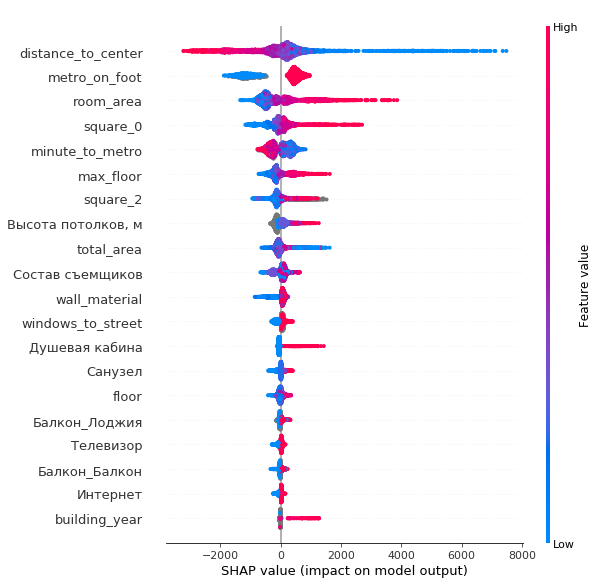

In [32]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df[features])
shap.summary_plot(shap_values, df[features])

## Добавим признаки связанные с ближайшими геообъектами
- Кафе
- Школы
- Детские сады
- Полицейские участки
- Банки

Для этого скачаем данные Open Street Maps

In [ ]:
%%bash
mkdir ../data
mkdir ../data/cent_fed
wget -O ../data/central-fed.shp.zip   http://download.geofabrik.de/russia/central-fed-district-latest-free.shp.zip
unzip ../data/central-fed.shp.zip -d ../data/cent_fed


In [37]:
%%bash
ls -l ../data/cent_fed/

total 5855512
-rw-rw-r--  1 p.logachev  staff        665 Oct  7 07:45 README
-rw-rw-r--  1 p.logachev  staff          6 Oct  7 07:43 gis_osm_buildings_a_free_1.cpg
-rw-rw-r--  1 p.logachev  staff  598370259 Oct  7 07:45 gis_osm_buildings_a_free_1.dbf
-rw-rw-r--  1 p.logachev  staff        144 Oct  7 07:43 gis_osm_buildings_a_free_1.prj
-rw-rw-r--  1 p.logachev  staff  554139560 Oct  7 07:45 gis_osm_buildings_a_free_1.shp
-rw-rw-r--  1 p.logachev  staff   29367956 Oct  7 07:45 gis_osm_buildings_a_free_1.shx
-rw-rw-r--  1 p.logachev  staff          6 Oct  7 07:43 gis_osm_landuse_a_free_1.cpg
-rw-rw-r--  1 p.logachev  staff  141542133 Oct  7 07:45 gis_osm_landuse_a_free_1.dbf
-rw-rw-r--  1 p.logachev  staff        144 Oct  7 07:43 gis_osm_landuse_a_free_1.prj
-rw-rw-r--  1 p.logachev  staff  568397764 Oct  7 07:45 gis_osm_landuse_a_free_1.shp
-rw-rw-r--  1 p.logachev  staff    7918532 Oct  7 07:45 gis_osm_landuse_a_free_1.shx
-rw-rw-r--  1 p.logachev  staff          6 Oct  7 07:43 gis_osm

Для поиска ближайших соседей переведем все координаты из долготы и широты в расстояния по долготе и широте от центра Москвы

In [39]:
lat_meters = 111300
lon_meters = 57476

def center_lat_to_meter(lat):
    return (lat - center['lat']) * lat_meters

def center_lon_to_meter(lon):
    return (lon - center['lon']) * lon_meters


In [40]:
df['lat_meter'] = df['lat'].apply(center_lat_to_meter)
df['lon_meter'] = df['lon'].apply(center_lon_to_meter)

формат этих файлов .shp, в них хранится информация о геометрии объекта, класс и название. Можно итерироваться по этим объектам с помощью функции reader.iterShapeRecords() которая возвращает генератор. Каждый объект содержит два поля record и shаpe

In [41]:
import shapefile

In [42]:
reader = shapefile.Reader('../data/cent_fed/gis_osm_pois_free_1')

Пройдемся по всем записям и сохраним лишь те, что рассположены на расстоянии 40 км

In [43]:
max_distance  = 40000
out = []
for point in reader.iterShapeRecords():
    lon, lat = np.mean(point.shape.points, axis=0)
    lat_meter =  center_lat_to_meter(lat)
    lon_meter = center_lon_to_meter(lon)
    if np.abs(lat_meter) > max_distance or np.abs(lon_meter) > max_distance :
        continue
    out.append({'category': point.record[2], 
                'lat': lat, 
                'lon': lon,
                'lat_meter': lat_meter,
                'lon_meter': lon_meter,
               })

In [44]:
df_poi = pd.DataFrame(out)

Посмотрим, где расположены школы в Москве

In [45]:
df_cafe = df_poi[df_poi['category'] == 'school']

In [46]:
map_folium = folium.Map(location=(center['lat'], center['lon']),
                        tiles='Stamen Toner',
                        zoom_start=11)
for ind, row in df_cafe.iterrows():
    folium.CircleMarker([row['lat'], row['lon']],
                        radius=1,
                        fill=True, 
                        fill_opacity=0.9
                       ).add_to(map_folium)
map_folium

Для быстрого поиска ближайших объектов к определенной точки, создадим структуру данных KDTree и будем делать запросы к ней

In [47]:
from scipy import spatial

In [48]:
kdtree = spatial.KDTree(df_poi[['lat_meter', 'lon_meter']].values)

Первый элемет - расстояние, второй - индекс

In [49]:
kdtree.query([55, 37], 4)

(array([ 20.77675998,  21.55709842,  21.76028261,  22.12623911]),
 array([45746, 45743, 45737, 45745]))

Объекты в радиусе

In [50]:
kdtree.query_ball_point([55, 37], 30)

[33376, 45736, 45737, 45738, 45740, 45743, 45745, 45746, 45749, 45751, 45759]

Пройдемся по категориям, которые посчитали, что внесут вклад в уточнение стоимости и посчитаем средние расстояния до этих объектов среди 1 и 5 соседей и количество объектов в радиусе 500 и 1000 метров

In [51]:
important_category_poi = ['cinema', 'supermarket', 'cafe', 'police', 
                          'museum', 'fast_food', 'bank', 'beauty_shop',
                          'school']

In [52]:
for cat in tqdm(important_category_poi):
    df_poi_cat = df_poi[df_poi['category'] == cat]
    df_poi_cat = df_poi_cat.reset_index(drop=True)
    kdtree = spatial.KDTree(df_poi_cat[['lat_meter', 'lon_meter']].values)
    distances = kdtree.query(df[['lat_meter', 'lon_meter']].values, 16)[0]
    for nearest in [1, 5]:
        df[f'distance_to_{cat}_between_{nearest}'] = np.mean(distances[:, :nearest], axis=1)
        
    for distance in [500, 1000]:
        nearests = kdtree.query_ball_point(df[['lat_meter', 'lon_meter']].values, distance)
        df[f'nearest_{cat}_within_{distance}'] = nearests
        df[f'nearest_{cat}_within_{distance}'] = df[f'nearest_{cat}_within_{distance}'].apply(len)

100%|██████████| 9/9 [00:41<00:00,  4.64s/it]


Снова обучим модель и посмотрим на сколько изменилось качество

In [53]:
trash_columns += ['lat_meter', 'lon_meter']

In [54]:
features = list(set(df.columns) - set(trash_columns + [target]))

In [55]:
train, test = train_test_split(df, random_state=1337)

lgb_data_train = lgb.Dataset(train[features].values, train[target])
lgb_data_test = lgb.Dataset(test[features].values, test[target])
params = {
    'objective':'regression', 
    'metric': 'mae',
    'learning_rate': 0.04, 
    'nthread': 1,
    'reg_lambda': 30,
    'subsample': 0.9,
    'feature_fraction': 0.9
}

model = lgb.train(params, lgb_data_train, 
                  valid_sets=[lgb_data_test, lgb_data_train],
                  num_boost_round=3500,
                  early_stopping_rounds=100, verbose_eval=40)

Training until validation scores don't improve for 100 rounds
[40]	training's l1: 2110.18	valid_0's l1: 2296.95
[80]	training's l1: 1804.12	valid_0's l1: 2167.09
[120]	training's l1: 1612.37	valid_0's l1: 2128.34
[160]	training's l1: 1457.25	valid_0's l1: 2116.69
[200]	training's l1: 1328.13	valid_0's l1: 2115.52
[240]	training's l1: 1216.17	valid_0's l1: 2117.56
[280]	training's l1: 1115.95	valid_0's l1: 2119.24
Early stopping, best iteration is:
[184]	training's l1: 1378.62	valid_0's l1: 2112.86


In [56]:
model.predict(test[test['ID  объявления'] == 'gz_room'][features])

array([ 16633.89499722])

In [57]:
(pd.DataFrame({'name': features, 
              'importance': model.feature_importance()})
 .sort_values('importance', ascending=False)
 .head(25))

,importance,name
54,328,distance_to_center
17,242,room_area
34,235,minute_to_metro
50,234,distance_to_cinema_between_5
1,202,total_area
9,183,distance_to_cinema_between_1
64,180,distance_to_supermarket_between_5
31,179,square_2
21,171,distance_to_museum_between_5
38,170,square_0


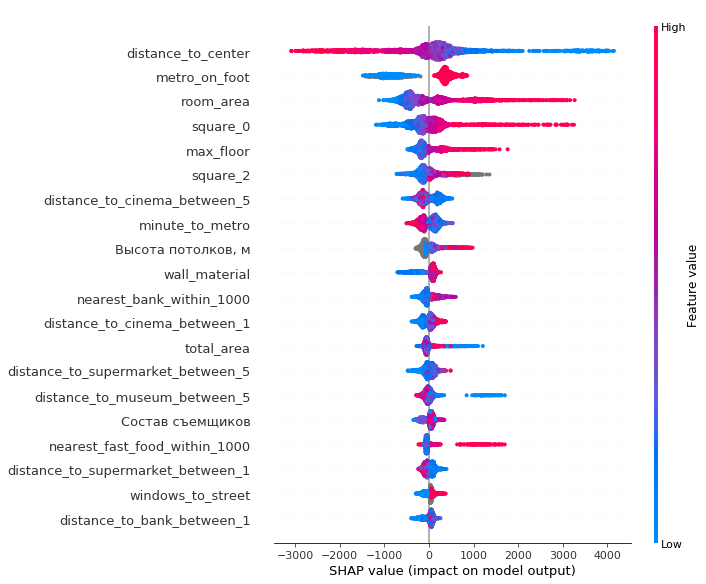

In [58]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df[features])
shap.summary_plot(shap_values, df[features])